# Helpfulness Classification

In [28]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error, mean_absolute_error, classification_report
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    # DistilBertConfig,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
)
from datasets import (
    load_dataset, load_metric, DatasetDict, Dataset
)
import evaluate

device = "cuda" if torch.cuda.is_available() else "cpu"
!nvidia-smi

Mon Apr 24 21:06:20 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-PCIE-32GB            Off| 00000000:18:00.0 Off |                    0 |
| N/A   40C    P0               41W / 250W|   1160MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 1. Data Preparation

### 1.1 Loading the "Helpful Sentences from Reviews" Dataset

In [29]:
# Path of dataset
data_files = {"train": "./data/train.json", "test": "./data/test.json"}

# Load dataset
dataset = load_dataset("json", data_files=data_files["test"], split='train')\
          .remove_columns(["asin", "main_image_url"])


# Split into train and test data -> 80% : 20%
split_dataset = dataset.train_test_split(train_size=0.8, seed=42) # Shuffled by default
split_dataset

Found cached dataset json (/local/home/p11333at/.cache/huggingface/datasets/json/default-a215bf8b0913c848/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51)
Loading cached split indices for dataset at /local/home/p11333at/.cache/huggingface/datasets/json/default-a215bf8b0913c848/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-507c488b89086b5a.arrow and /local/home/p11333at/.cache/huggingface/datasets/json/default-a215bf8b0913c848/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-8f3a243ad04e0776.arrow


DatasetDict({
    train: Dataset({
        features: ['sentence', 'helpful', 'product_title'],
        num_rows: 1600
    })
    test: Dataset({
        features: ['sentence', 'helpful', 'product_title'],
        num_rows: 400
    })
})

### 1.2 Preprocessing for the "Helpful Sentences from Reviews" Dataset

#### 1.2.1 Normalize the labels

In [30]:
"""The value of "helpfulness" is in range of 0 <= helpful <= 2,
   After this process, the value of "labels" is in range of 0 <= labels <= 1
"""
def normalize_labels(row):
    row["labels"] = row["helpful"]/2
    return row

labelled_dataset = split_dataset.map(normalize_labels)

Loading cached processed dataset at /local/home/p11333at/.cache/huggingface/datasets/json/default-a215bf8b0913c848/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-178208f7f68ddad0.arrow
Loading cached processed dataset at /local/home/p11333at/.cache/huggingface/datasets/json/default-a215bf8b0913c848/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-7069c12f54ab0aef.arrow


#### 1.2.2 Tokenizing for each sentence

In [ ]:
def tokenization(row):
    return tokenizer(
        row["sentence"], truncation=True, padding="max_length", max_length=70
    )

tokenized_dataset = labelled_dataset.map(tokenization, batched=True)

tokenized_dataset.set_format(
    type="torch", columns=["input_ids", "attention_mask", "labels"]
)
tokenized_dataset

## 2. Load BERT Model

In [31]:
# Additional setup
model_ckpt = "distilbert-base-uncased"

kwargs = {
    "num_labels": 1,
    "activation": "sigmoid",
}

bert_model = DistilBertForSequenceClassification.from_pretrained(model_ckpt, **kwargs)
bert_model = bert_model.to(device)  # Send the model to GPU if available

tokenizer = AutoTokenizer.from_pretrained(model_ckpt, **kwargs)

loading configuration file config.json from cache at /local/home/p11333at/.cache/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /local/home/p11333at/.cache/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/pytorch_model.bin
Some weights of the model checkpoint at distilbert-b

## 3. Experiments

### 3.1 Find the most appropriate max_length for padding of tokenizer

Loading cached processed dataset at /local/home/p11333at/.cache/huggingface/datasets/json/default-a215bf8b0913c848/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-1dd30e77018be3a5.arrow
Loading cached processed dataset at /local/home/p11333at/.cache/huggingface/datasets/json/default-a215bf8b0913c848/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-136b7b16b518a24e.arrow


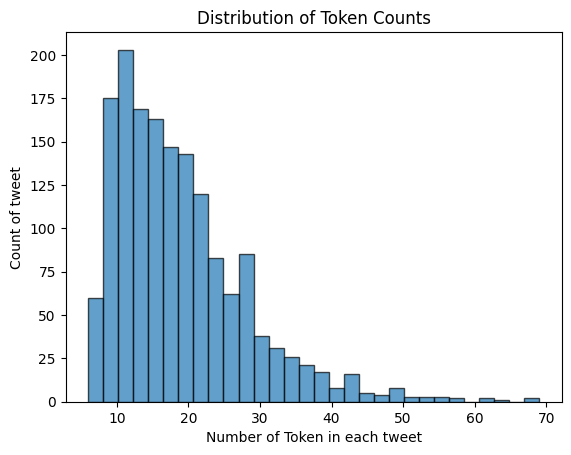

The max number of tokens in the dataset: 69


In [32]:
# Calculate the length of tokens in tokenized reviews
# (to help determine the max_length for padding)
trial_dataset = labelled_dataset.map(
    lambda row: tokenizer(row["sentence"]), 
    batched=True
)

input_token_length = np.array(
    [len(input_ids) for input_ids in trial_dataset['train']["input_ids"]], 
    # dtype=torch.float
)

plt.hist(input_token_length, bins=30, edgecolor='k', alpha=0.7)
plt.gca().set(
    title='Distribution of Token Counts', 
    xlabel='Number of Token in each sentences',
    ylabel='Count of tweet'
)

plt.show()

print(f"The max number of tokens in the dataset: {np.max(input_token_length)}")

### 3.2  Fine-tuning BERT Model

In [1]:
# Method for Computing Accuracy
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits).to(device), dim=-1).to(device)
    
    accuracy_metric = evaluate.load("accuracy")
    f1_metric = evaluate.load("f1")
    
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")["f1"]
    
    return {"accuracy": accuracy, "f1": f1}

def compute_metrics_for_regression(eval_pred):
    logits, labels = eval_pred
    labels = labels.reshape(-1, 1)

    mse = mean_squared_error(labels, logits)
    rmse = mean_squared_error(labels, logits, squared=False)
    mae = mean_absolute_error(labels, logits)
    r2 = r2_score(labels, logits)
    smape = 1/len(labels) * np.sum(2 * np.abs(logits-labels) / (np.abs(labels) + np.abs(logits))*100)

    return {"mse": mse, "rmse": rmse, "mae": mae, "r2": r2, "smape": smape}

# Use the following class if you want to self define the compute_loss function
class RegressionTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits')
        loss_fct = nn.MSELoss()
        loss = loss_fct(logits.squeeze(), labels.squeeze())
        return (loss, outputs) if return_outputs else loss

NameError: name 'Trainer' is not defined

In [37]:
training_args = TrainingArguments(
    output_dir="/local/home/p11333at/robotics/output",
    # output_dir="./output",
    num_train_epochs=8,
    learning_rate=3e-5,  # Default: 5e-05
    weight_decay=0.01,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    evaluation_strategy= "steps",    #"epoch",  # 'steps'
    eval_steps=100,
    logging_steps=100,
    logging_strategy= "steps",
    # logging_strategy="epoch",
    # gradient_accumulation_steps=8,
    metric_for_best_model="eval_mse",
    load_best_model_at_end=True,

)

early_stop = EarlyStoppingCallback(
    early_stopping_patience=3, 
    early_stopping_threshold=1.0
)


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [36]:
trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics_for_regression,
    callbacks=[early_stop]
)

trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, product_title, helpful. If sentence, product_title, helpful are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/local/home/p11333at/.conda/machine-learning/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1600
  Num Epochs = 15
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1500
  Number of trainable parameters = 66954241


Step,Training Loss,Validation Loss


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, product_title, helpful. If sentence, product_title, helpful are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 400
  Batch size = 16
***** Running Evaluation *****
  Num examples = 400
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, product_title, helpful. If sentence, product_title, helpful are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 400
  Batch size = 16
Saving model checkpoint to /local/home/p11333at/robotics/output/checkpoint-500
Configuration saved in /local/home/p11333at/robotics/output

TrainOutput(global_step=800, training_loss=0.015032105818390847, metrics={'train_runtime': 53.7316, 'train_samples_per_second': 446.664, 'train_steps_per_second': 27.917, 'total_flos': 231813813504000.0, 'train_loss': 0.015032105818390847, 'epoch': 8.0})

In [38]:
trainer.evaluate(tokenized_dataset["test"])

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, product_title, helpful. If sentence, product_title, helpful are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 400
  Batch size = 16


{'eval_loss': 0.014691910706460476,
 'eval_mse': 0.014691909775137901,
 'eval_rmse': 0.12121018767356873,
 'eval_mae': 0.09506548196077347,
 'eval_r2': 0.6181473612542687,
 'eval_smape': 20.7298291015625,
 'eval_runtime': 0.3831,
 'eval_samples_per_second': 1044.239,
 'eval_steps_per_second': 65.265,
 'epoch': 8.0}

In [39]:
res = trainer.predict(tokenized_dataset["test"])
predictions = res.predictions

for i in range(15):
    print(tokenized_dataset['test']['helpful'][i]/2, predictions[i])

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, product_title, helpful. If sentence, product_title, helpful are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 400
  Batch size = 16


0.4 [0.31259567]
0.7 [0.7670815]
0.75 [0.6998342]
0.535 [0.45056367]
0.3 [0.46338657]
0.665 [0.6585155]
0.735 [0.6269913]
0.515 [0.69655657]
0.35 [0.5445718]
0.6 [0.3732288]
0.45 [0.5645105]
0.235 [0.27114987]
0.365 [0.17743345]
0.735 [0.6053233]
0.515 [0.5510365]


In [40]:
metrics = res.metrics
print(f''' ------ Metrics ------
Mean Squared Error:         {metrics['test_mse']:.2f}
Root Mean Squared Error:    {metrics['test_rmse']:.2f}
Mean Absolute Error:        {metrics['test_mae']:.2f}
R2 Score:                   {metrics['test_r2']:.2f}
Symmetric Mean Absolute Percentage Error: {metrics['test_smape']:.2f}
''')

 ------ Metrics ------
Mean Squared Error:         0.01
Root Mean Squared Error:    0.12
Mean Absolute Error:        0.10
R2 Score:                   0.62
Symmetric Mean Absolute Percentage Error: 20.73



### 3.3  Ensemble Learning


In [41]:
from sklearn.model_selection import KFold

k_fold = 5
ensemble_size = 10
ensemble_checkpoint_path = '/local/home/p11333at/nlu/'

tokenized_unsplit_dataset = dataset.map(normalize_labels).map(tokenization, batched=True)

tokenized_unsplit_dataset.set_format(
    type="torch", columns=["input_ids", "attention_mask", "labels"]
)
tokenized_unsplit_dataset

Loading cached processed dataset at /local/home/p11333at/.cache/huggingface/datasets/json/default-a215bf8b0913c848/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-69de3334dfc33037.arrow
Loading cached processed dataset at /local/home/p11333at/.cache/huggingface/datasets/json/default-a215bf8b0913c848/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-13f2c84560412e59.arrow


Dataset({
    features: ['sentence', 'helpful', 'product_title', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 2000
})

In [44]:
skf = KFold(n_splits=k_fold, shuffle=True, random_state=42)

results = []
# Loop for each fold
for fold, (train_idx, valid_idx) in enumerate(skf.split(tokenized_unsplit_dataset)):
    print(f"\033[1;37;42m    ==============  {fold+1}/{k_fold} Fold  ==============    \033[0m")

    # Split dataset & Create the DataLoader
    train_dataset = tokenized_unsplit_dataset.select(train_idx)
    valid_dataset = tokenized_unsplit_dataset.select(valid_idx)



    evaluation_list = []
    prediction_list = []
    for i in range(ensemble_size):
        print(f"\033[1;34;47m    ==========  {i+1}/{ensemble_size} of ensemble  ==========    \033[0m")

        
        # Initialise bootstrap sample index
        dataset_size = len(train_dataset)
        np.random.seed(42+i)
        bootstrap_index = np.random.choice(dataset_size, dataset_size, replace=True)

        # Retrieve the bootstrap sample
        sample_dataset = train_dataset.select(bootstrap_index)

        print(f"Dataset size: {dataset_size}")
        print(f"Number of distinct data in Bootstrap sample: {len(set(bootstrap_index))}")

        # Instantiate the Model
        bert_model = DistilBertForSequenceClassification.from_pretrained(model_ckpt, **kwargs)
        bert_model = bert_model.to(device)  # Send the model to GPU if available

        trainer = Trainer(
            model=bert_model,
            args=training_args,
            train_dataset=sample_dataset,
            eval_dataset=valid_dataset,
            compute_metrics=compute_metrics_for_regression,
            callbacks=[early_stop]
        )
        
        trainer.train()

        # Emsemble prediction
        eval_result = trainer.predict(valid_dataset)
        evaluation_list.append(eval_result)
        prediction_list.append(eval_result.predictions)

        # Save the model checkpoint
        bert_model.save_pretrained(ensemble_checkpoint_path+f"member_{fold+1}_{i+1}.pt")

        # Relsase GPU memory
        del bert_model, trainer
        torch.cuda.empty_cache()
    

    # Ensemble prediction
    prediction_list = np.array(prediction_list)
    metrics_list = [res.metrics for res in evaluation_list]
    ensemble_predictions = np.mean(prediction_list, axis=0).squeeze()

    # Store the results of each fold
    # results.append([metrics_list, predictions_list, ensemble_predictions, valid_labels])
    results.append([valid_dataset['labels'], ensemble_predictions, prediction_list])

    ######
    break##
    ######

loading configuration file config.json from cache at /local/home/p11333at/.cache/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /local/home/p11333at/.cache/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/pytorch_model.bin


    ==============  1/5 Fold  ==============    
    ==========  1/10 of ensemble  ==========    
Dataset size: 1600
Number of distinct data in Bootstrap sample: 997


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifi

Step,Training Loss,Validation Loss


Configuration saved in /local/home/p11333at/nlu/member_1_1.pt/config.json
Model weights saved in /local/home/p11333at/nlu/member_1_1.pt/pytorch_model.bin
loading configuration file config.json from cache at /local/home/p11333at/.cache/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /local/home/p11333at/.cache

    ==========  2/10 of ensemble  ==========    
Dataset size: 1600
Number of distinct data in Bootstrap sample: 1014


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifi

Step,Training Loss,Validation Loss


Configuration saved in /local/home/p11333at/nlu/member_1_2.pt/config.json
Model weights saved in /local/home/p11333at/nlu/member_1_2.pt/pytorch_model.bin
loading configuration file config.json from cache at /local/home/p11333at/.cache/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /local/home/p11333at/.cache

    ==========  3/10 of ensemble  ==========    
Dataset size: 1600
Number of distinct data in Bootstrap sample: 1012


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifi

Step,Training Loss,Validation Loss


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, product_title, helpful. If sentence, product_title, helpful are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 400
  Batch size = 16
***** Running Evaluation *****
  Num examples = 400
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, product_title, helpful. If sentence, product_title, helpful are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 400
  Batch size = 16
Saving model checkpoint to /local/home/p11333at/robotics/output/checkpoint-500
Configuration saved in /local/home/p11333at/robotics/output

Configuration saved in /local/home/p11333at/nlu/member_1_3.pt/config.json
Model weights saved in /local/home/p11333at/nlu/member_1_3.pt/pytorch_model.bin
loading configuration file config.json from cache at /local/home/p11333at/.cache/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /local/home/p11333at/.cache

    ==========  4/10 of ensemble  ==========    
Dataset size: 1600
Number of distinct data in Bootstrap sample: 1019


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifi

Step,Training Loss,Validation Loss


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, product_title, helpful. If sentence, product_title, helpful are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 400
  Batch size = 16
***** Running Evaluation *****
  Num examples = 400
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, product_title, helpful. If sentence, product_title, helpful are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, product_title, 

Configuration saved in /local/home/p11333at/nlu/member_1_4.pt/config.json
Model weights saved in /local/home/p11333at/nlu/member_1_4.pt/pytorch_model.bin
loading configuration file config.json from cache at /local/home/p11333at/.cache/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /local/home/p11333at/.cache

    ==========  5/10 of ensemble  ==========    
Dataset size: 1600
Number of distinct data in Bootstrap sample: 1008


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifi

Step,Training Loss,Validation Loss


Configuration saved in /local/home/p11333at/nlu/member_1_5.pt/config.json
Model weights saved in /local/home/p11333at/nlu/member_1_5.pt/pytorch_model.bin
loading configuration file config.json from cache at /local/home/p11333at/.cache/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /local/home/p11333at/.cache

    ==========  6/10 of ensemble  ==========    
Dataset size: 1600
Number of distinct data in Bootstrap sample: 1016


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifi

Step,Training Loss,Validation Loss


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, product_title, helpful. If sentence, product_title, helpful are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 400
***** Running Evaluation *****
  Num examples = 400
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, product_title, helpful. If sentence, product_title, helpful are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 400
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, product_titl

Configuration saved in /local/home/p11333at/nlu/member_1_6.pt/config.json
Model weights saved in /local/home/p11333at/nlu/member_1_6.pt/pytorch_model.bin
loading configuration file config.json from cache at /local/home/p11333at/.cache/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /local/home/p11333at/.cache

    ==========  7/10 of ensemble  ==========    
Dataset size: 1600
Number of distinct data in Bootstrap sample: 1018


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifi

Step,Training Loss,Validation Loss


Configuration saved in /local/home/p11333at/nlu/member_1_7.pt/config.json
Model weights saved in /local/home/p11333at/nlu/member_1_7.pt/pytorch_model.bin
loading configuration file config.json from cache at /local/home/p11333at/.cache/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /local/home/p11333at/.cache

    ==========  8/10 of ensemble  ==========    
Dataset size: 1600
Number of distinct data in Bootstrap sample: 1030


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifi

Step,Training Loss,Validation Loss


Configuration saved in /local/home/p11333at/nlu/member_1_8.pt/config.json
Model weights saved in /local/home/p11333at/nlu/member_1_8.pt/pytorch_model.bin
loading configuration file config.json from cache at /local/home/p11333at/.cache/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /local/home/p11333at/.cache

    ==========  9/10 of ensemble  ==========    
Dataset size: 1600
Number of distinct data in Bootstrap sample: 1038


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifi

Step,Training Loss,Validation Loss


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, product_title, helpful. If sentence, product_title, helpful are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 400
***** Running Evaluation *****
  Num examples = 400
Saving model checkpoint to /local/home/p11333at/robotics/output/checkpoint-500
Configuration saved in /local/home/p11333at/robotics/output/checkpoint-500/config.json
Saving model checkpoint to /local/home/p11333at/robotics/output/checkpoint-500
Configuration saved in /local/home/p11333at/robotics/output/checkpoint-500/config.json
Model weights saved in /local/home/p11333at/robotics/output/checkpoint-500/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from /local/home/p11333at/robotics/outpu

Configuration saved in /local/home/p11333at/nlu/member_1_9.pt/config.json
Model weights saved in /local/home/p11333at/nlu/member_1_9.pt/pytorch_model.bin
loading configuration file config.json from cache at /local/home/p11333at/.cache/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /local/home/p11333at/.cache

    ==========  10/10 of ensemble  ==========    
Dataset size: 1600
Number of distinct data in Bootstrap sample: 1015


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifi

Step,Training Loss,Validation Loss


Configuration saved in /local/home/p11333at/nlu/member_1_10.pt/config.json
Model weights saved in /local/home/p11333at/nlu/member_1_10.pt/pytorch_model.bin


THE END

### 3.4  A set of Experiments



In [2]:
# For single model
# true = tokenized_dataset['test']['labels'].cpu().numpy()    # Extract true labels (Detach from GPU as well)
# pred = np.squeeze(predictions)  # Convert matrix to 1D array

# For ensemble model
true, pred = results[0][0].cpu().numpy(), results[0][1]

NameError: name 'results' is not defined

#### 3.4.1 Experiment1: Two classes classification (classify a review as "Helpful" or "Not Helpful")

Evaluation Metrics:






In [46]:

# 0-1 | 1-2
def convert_value_to_2_labels(true, pred):
    true = true*2
    pred = pred*2
    bins = [0, 1, 2]
    true_classes = np.digitize(true, bins)
    pred_classes = np.digitize(pred, bins)
    return true_classes, pred_classes

lable_true, label_pred = convert_value_to_2_labels(true, pred)

print("\n------ Classification Report for ( 2 ) Labels ------")
print(classification_report(lable_true, label_pred, target_names=["Not Helpful", "Helpful"]))



------ Classification Report for ( 2 ) Labels ------
              precision    recall  f1-score   support

 Not Helpful       0.73      0.76      0.75       141
     Helpful       0.87      0.85      0.86       259

    accuracy                           0.82       400
   macro avg       0.80      0.80      0.80       400
weighted avg       0.82      0.82      0.82       400


------ Classification Report for ( 3 ) Labels ------
                  precision    recall  f1-score   support

     Not Helpful       0.63      0.56      0.59        61
Slightly Helpful       0.69      0.77      0.73       209
    Very Helpful       0.73      0.64      0.68       130

        accuracy                           0.69       400
       macro avg       0.68      0.65      0.67       400
    weighted avg       0.69      0.69      0.69       400


------ Classification Report for ( 4 ) Labels ------
                  precision    recall  f1-score   support

     Not Helpful       0.52      0.33      

#### 3.4.2 Experiment2: Three classes classification (Classify a review as "Not Helpful", "Slightly Helpful" or "Very Helpful")

Evaluation Metrics:

In [ ]:

# 0-0.66 | 0.66-1.33 | 1.33-2
def convert_value_to_3_labels(true, pred):
    true = true*2
    pred = pred*2
    bins = [0, 0.66, 1.33, 2]
    true_classes = np.digitize(true, bins)
    pred_classes = np.digitize(pred, bins)
    return true_classes, pred_classes

lable_true, label_pred = convert_value_to_3_labels(true, pred)

print("\n------ Classification Report for ( 3 ) Labels ------")
print(classification_report(lable_true, label_pred, target_names=["Not Helpful", "Slightly Helpful", "Very Helpful"]))



#### 3.4.3 Four classes classification (Classify a review as "Not Helpful", "Slightly Helpful", "Helpful" or "Very Helpful")

Evaluation Metrics:



In [ ]:
# 0-0.5 | 0.5-1.0 | 1.0-1.5 | 1.5-2
def convert_value_to_4_labels(true, pred):
    true = true*2
    pred = pred*2
    bins = [0, 0.5, 1, 1.5, 2]
    true_classes = np.digitize(true, bins)
    pred_classes = np.digitize(pred, bins)
    return true_classes, pred_classes

lable_true, label_pred = convert_value_to_4_labels(true, pred)

print("\n------ Classification Report for ( 4 ) Labels ------")
print(classification_report(lable_true, label_pred, target_names=["Not Helpful", "Slightly Helpful", "Helpful", "Very Helpful"]))



#### 3.4.4 Five classes classification (Classify a review as "Not Helpful", "Slightly Helpful", "Helpful", "Very Helpful" or "Extremely Helpful")

Evaluation Metrics:

In [ ]:
# 0-0.4 | 0.4-0.8 | 0.8-1.2 | 1.2-1.6 | 1.6-2
def convert_value_to_5_labels(true, pred):
    true = true*2
    pred = pred*2
    bins = [0, 0.4, 0.8, 1.2, 1.6, 2]
    true_classes = np.digitize(true, bins)
    pred_classes = np.digitize(pred, bins)
    return true_classes, pred_classes

lable_true, label_pred = convert_value_to_5_labels(true, pred)

print("\n------ Classification Report for ( 5 ) Labels ------")
print(classification_report(lable_true, label_pred, target_names=["Not Helpful", "Slightly Helpful", "Helpful", "Very Helpful", "Extremely Helpful"]))

#### 3.5 The overall performance of the label

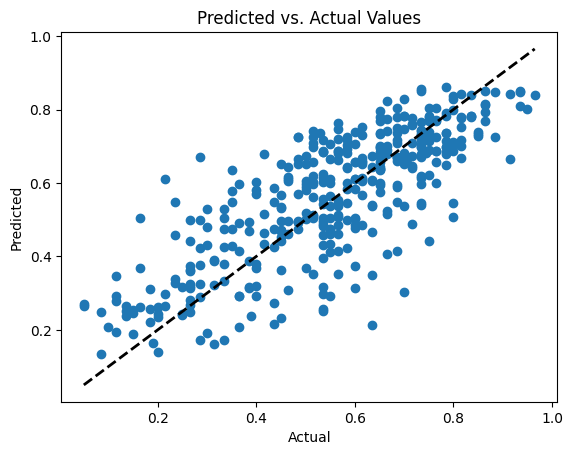

In [17]:
plt.scatter(true, pred)
plt.plot([true.min(), true.max()], [true.min(), true.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs. Actual Values')
plt.show()


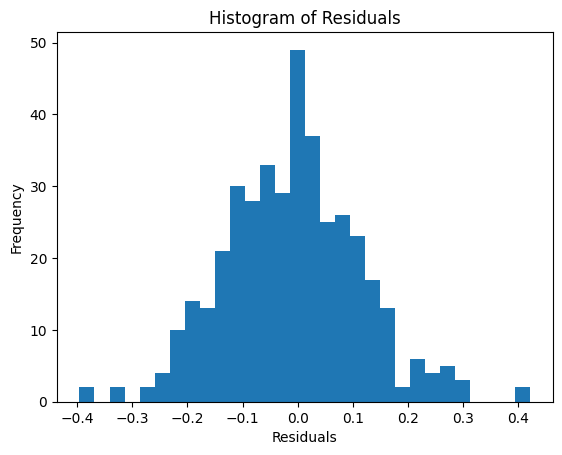

In [18]:
residuals = true - pred

plt.hist(residuals, bins=30)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()


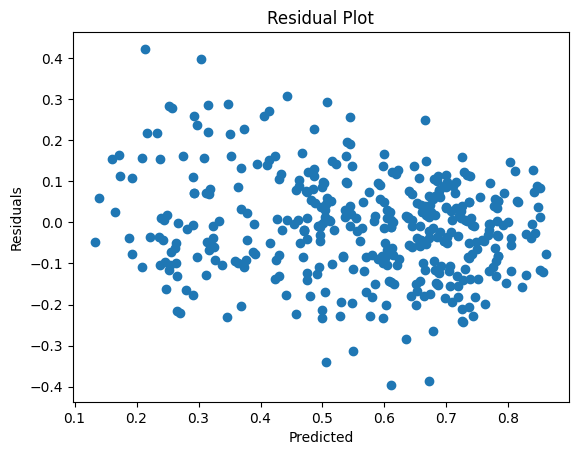

In [19]:
plt.scatter(pred, residuals)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()
